# To evaluta the network of classifer, we traned the model on GTSRB dataset

Thanks for the great selfless tutorial:  https://chsasank.github.io/keras-tutorial.html

In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.cross_validation import train_test_split
import os
import glob
import h5py
from time import time
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Merge
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.regularizers import l2


from keras import backend as K
import numpy as np


from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


NUM_CLASSES = 43
IMG_SIZE = 48

/home/jia/.virtualenvs/keras_tf/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


## Function to preprocess the image:

In [2]:
def preprocess_img(img):
    # Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)
    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    # //代表 整数除法
    # rescale to standard size  
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    # 注意对于tensorflow和theano通道顺序的不同
    # roll color axis to axis 0
    #img = np.rollaxis(img,-1)

    return img


def get_class(img_path):
    return int(img_path.split('/')[-2])

## Preprocess all training images into a numpy array

In [3]:
try:
    with  h5py.File('X.h5') as hf: 
        X, Y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = '/home/jia/Desktop/traffic_sign_keras1.2/GTSRB_Train_images/Final_Training/Images/'
    imgs = []
    labels = []

    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    #打乱图片路径顺序
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            
            # io.imread 读入的数据是 uint8
            
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
    # Y = ***[labels] 生成one-hot编码的方式
    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Loaded images from X.h5


# Load and Preprocess Test images

In [4]:
try:
    with  h5py.File('X_test.h5') as hf: 
        X_test, y_test = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X_test.h5")
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    import pandas as pd
    test = pd.read_csv('/home/jia/Desktop/traffic_sign_keras1.2/GTSRB_Test_images/Final_Test/Images/GT-final_test.csv',sep=';')

    
    X_test = []
    y_test = []
    i = 0
    for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
        img_path = os.path.join('/home/jia/Desktop/CS231N_AND_traffic_sign_keras1.2/GTSRB_Test_images/Final_Test/Images/',file_name)
        X_test.append(preprocess_img(io.imread(img_path)))
        y_test.append(class_id)

    X_test = np.array(X_test, dtype='float32')
    y_test = np.array(y_test, dtype='uint8')

    with h5py.File('X_test.h5','w') as hf:
        hf.create_dataset('imgs', data=X_test)
        hf.create_dataset('labels', data=y_test)

Loaded images from X_test.h5


In [5]:
index=np.zeros(1307, dtype='int')
for i in range(1307):
    index[i]=i*30+np.random.randint(0,30) 

X_val = X[index]
y_val = Y[index]
# creat the training index1
index1=np.setdiff1d(np.array(range(39210)), index, assume_unique=True)
X_train=X[index1]
y_train=Y[index1]

normalize = 0
# Normalize the data: subtract the mean image
if normalize:
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image


print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (37903, 48, 48, 3)
Train labels shape:  (37903, 43)
Validation data shape:  (1307, 48, 48, 3)
Validation labels shape:  (1307, 43)
Test data shape:  (12630, 48, 48, 3)
Test labels shape:  (12630,)


# Show Traffic Sign Examples

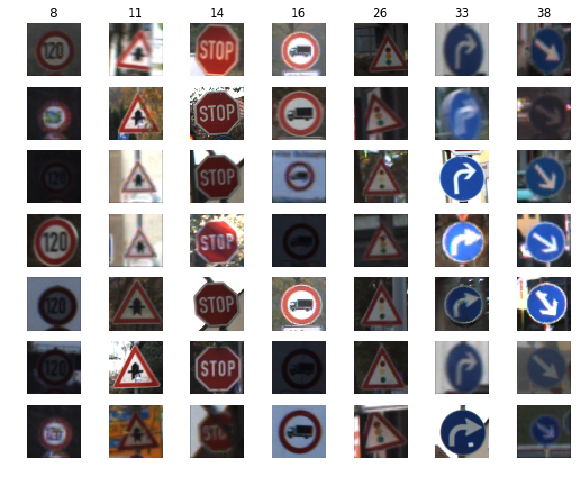

In [17]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [8, 11, 14,16, 26, 33, 38]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == cls)  #返回扁平化数组之后非0元素的index, y是数字标签
    idxs = np.random.choice(idxs, samples_per_class, replace=False)    #replace=False 使得随即选取的没有重复的
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        img=X_test[idx].copy() 
        plt.imshow(img)     #X原始是float64,图像显示要变成uint8
        plt.axis('off')  #取消axis的显示
        if i == 0:
            plt.title(cls)

In [18]:
foo_fig = plt.gcf()  # 'get current figure'
#foo_fig.savefig('foo.eps', format='eps', dpi=1000)
foo_fig.savefig('jiatong.png', format='png', dpi=300)
plt.close()

# Initialization of Weights

In [6]:
from keras import backend as K
import numpy as np

def my_init(shape, name=None):
    value = np.random.random(shape)
    return K.variable(value, name=name)

# Define Keras model

In [52]:
# 注意keras使用tensorflow和thano不同后台， 数据输入的通道顺序不同哦
def cnn_model():
    branch_0= Sequential()
    branch_1 = Sequential()
    model0 = Sequential()
    model = Sequential()
    # ********************************************** 48*48
    model0.add(Convolution2D(32, 3, 3, border_mode='same', init='he_normal' , input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model0.add(BatchNormalization(epsilon=1e-06, axis=3))
    model0.add(Activation('relu'))
  
    model0.add(Convolution2D(48, 7, 1, border_mode='same', init='he_normal'))
    model0.add(BatchNormalization(epsilon=1e-06, axis=3))
    model0.add(Activation('relu'))
    model0.add(Convolution2D(48, 1, 7, border_mode='same', init='he_normal'))
    model0.add(BatchNormalization(epsilon=1e-06, axis=3))
    model0.add(Activation('relu'))   
    model0.add(MaxPooling2D(pool_size=(2, 2)))
    model0.add(Dropout(0.2))
    # ****************************************** 24*24
    branch_0.add(model0)
    branch_1.add(model0)
    
    branch_0.add(Convolution2D(64, 3, 1, border_mode='same', init='he_normal'))
    branch_0.add(BatchNormalization(epsilon=1e-06, axis=3))
    branch_0.add(Activation('relu'))
    branch_0.add(Convolution2D(64, 1, 3, border_mode='same', init='he_normal'))
    branch_0.add(BatchNormalization(epsilon=1e-06,  axis=3))
    branch_0.add(Activation('relu'))
    
    branch_1.add(Convolution2D(64, 1, 7, border_mode='same', init='he_normal'))
    branch_1.add(BatchNormalization(epsilon=1e-06, axis=3))
    branch_1.add(Activation('relu'))
    branch_1.add(Convolution2D(64, 7, 1, border_mode='same', init='he_normal'))
    branch_1.add(BatchNormalization(epsilon=1e-06, axis=3))
    branch_1.add(Activation('relu'))    
    
    model.add(Merge([branch_0, branch_1], mode='concat', concat_axis=-1))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # ******************************************* 12*12
    model.add(Convolution2D(128, 3, 3, border_mode='same', init='he_normal'))
    model.add(BatchNormalization(epsilon=1e-06, axis=3))
    
    model.add(Activation('relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', init='he_normal'))   # 之前是256个滤波器
    model.add(BatchNormalization(epsilon=1e-06, axis=3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    # *************************************** 6*6
    model.add(Flatten())
    model.add(Dense(256, init='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(NUM_CLASSES, activation='softmax', init='he_normal'))
    return model


model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.001
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
adm = Adam(lr=0.001, decay=1e-6)  #之前没有设置decay
model.compile(loss='categorical_crossentropy',
              optimizer=adm,
              metrics=['accuracy'])


def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch/10))

# Plot and Save the model

In [109]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

# Start Training

In [53]:
batch_size = 16
nb_epoch = 30
t1=time()

history = model.fit(X_train, y_train, batch_size=batch_size, 
                            nb_epoch=nb_epoch,
                            validation_data=(X_val, y_val),
                            shuffle = True
         )
t2=time()
print (t2-t1)

Train on 37903 samples, validate on 1307 samples
Epoch 1/30
37903/37903 [==============================] - 55s - loss: 0.5172 - acc: 0.8621 - val_loss: 0.0572 - val_acc: 0.9809
Epoch 2/30
37903/37903 [==============================] - 53s - loss: 0.0670 - acc: 0.9804 - val_loss: 0.0270 - val_acc: 0.9931 0.0672 -  - ETA: 0s - loss: 0.0671 
Epoch 3/30
37903/37903 [==============================] - 53s - loss: 0.0441 - acc: 0.9865 - val_loss: 0.0130 - val_acc: 0.9969
Epoch 4/30
37903/37903 [==============================] - 53s - loss: 0.0281 - acc: 0.9914 - val_loss: 0.0092 - val_acc: 0.9969
Epoch 5/30
37903/37903 [==============================] - 53s - loss: 0.0254 - acc: 0.9920 - val_loss: 8.2585e-04 - val_acc: 1.0000
Epoch 6/30
37903/37903 [==============================] - 55s - loss: 0.0200 - acc: 0.9938 - val_loss: 3.3324e-04 - val_acc: 1.0000
Epoch 7/30
37903/37903 [==============================] - 54s - loss: 0.0156 - acc: 0.9951 - val_loss: 0.0305 - val_acc: 0.9931
Epoch 8/30


# Test on the Test Dataset

In [54]:
t1=time()
y_pred = model.predict_classes(X_test)
t2=time()
acc = np.mean(y_pred==y_test)
print("Test accuracy = {}".format(acc))
print  (t2-t1)

12576/12630 [============================>.] - ETA: 0sTest accuracy = 0.985193982581
5.26057291031


# Plot the Training History

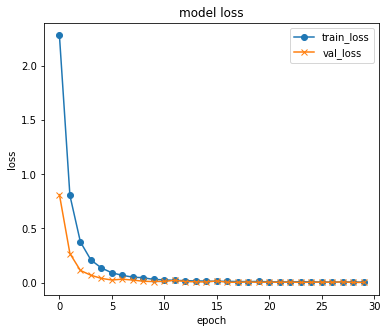

In [12]:
plt.figure(figsize=(6,5)) 
plt.plot(history.history['loss'], '-o')
plt.plot(history.history['val_loss'], '-x')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

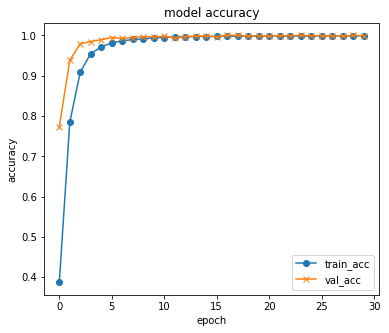

In [13]:
plt.figure(figsize=(6,5)) 
plt.plot(history.history['acc'], '-o')
plt.plot(history.history['val_acc'], '-x')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()

# Load Test data

In [ ]:
# 将类别标签转换成为 one-hot 编码, 如果需要的话
#from keras.utils.np_utils import to_categorical
#y_test1 = to_categorical(y_test, 43)

# With Data augmentation

In [29]:
from sklearn.cross_validation import train_test_split



datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

datagen.fit(X_train)

In [42]:
# # Reinstallise models 

# model = cnn_model()
# # let's train the model using SGD + momentum (how original).
# lr = 0.001
# sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#           optimizer=adm,
#           metrics=['accuracy'])


# def lr_schedule(epoch):
#     return lr*(0.1**int(epoch/10))

# Training based on the former model

In [55]:
nb_epoch = 200
history2=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                            samples_per_epoch=X_train.shape[0],
                            nb_epoch=nb_epoch,
                            validation_data=(X_val, y_val),
                            callbacks=[ReduceLROnPlateau('val_loss', factor=0.2, patience=20, verbose=1, mode='auto'), 
                                       ModelCheckpoint('model_final.h5',save_best_only=True)]
                           )

Epoch 1/200
37903/37903 [==============================] - 55s - loss: 0.2350 - acc: 0.9482 - val_loss: 3.3871e-05 - val_acc: 1.0000
Epoch 2/200
37903/37903 [==============================] - 54s - loss: 0.0847 - acc: 0.9768 - val_loss: 4.3330e-05 - val_acc: 1.0000
Epoch 3/200
37903/37903 [==============================] - 54s - loss: 0.0598 - acc: 0.9826 - val_loss: 1.4205e-04 - val_acc: 1.0000
Epoch 4/200
37903/37903 [==============================] - 54s - loss: 0.0466 - acc: 0.9863 - val_loss: 2.8224e-04 - val_acc: 1.0000
Epoch 5/200
37903/37903 [==============================] - 54s - loss: 0.0393 - acc: 0.9885 - val_loss: 5.0050e-04 - val_acc: 1.0000
Epoch 6/200
37903/37903 [==============================] - 55s - loss: 0.0366 - acc: 0.9898 - val_loss: 0.0013 - val_acc: 0.9992
Epoch 7/200
37903/37903 [==============================] - 55s - loss: 0.0332 - acc: 0.9902 - val_loss: 1.0094e-04 - val_acc: 1.0000
Epoch 8/200
37903/37903 [==============================] - 55s - loss: 0.

In [57]:
model.save('my_model_99.66.h5')

In [56]:
t1=time()
y_pred = model.predict_classes(X_test)
t2=time()
acc = np.mean(y_pred==y_test)
print("Test accuracy = {}".format(acc))
print  (t2-t1)

12544/12630 [============================>.] - ETA: 0sTest accuracy = 0.996595407759
5.07734417915


In [58]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sequential_15 (Sequential)       (None, 24, 24, 48)    28384                                        
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 24, 24, 64)    9280                                         
____________________________________________________________________________________________________
batchnormalization_34 (BatchNorm (None, 24, 24, 64)    256                                          
____________________________________________________________________________________________________
activation_34 (Activation)       (None, 24, 24, 64)    0                                            
___________________________________________________________________________________________

In [19]:
model.count_params()

2917259